In [214]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load data


In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import eli5 # Feature importance evaluation

In [216]:
# df = pd.read_csv('/content/drive/MyDrive/527/hotel_bookings.csv') #for Leting Sun
df = pd.read_csv('/content/drive/MyDrive/hotel_bookings.csv') # For Ken

In [217]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# getting data information

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# data cleaning


In [219]:
nullArray = df.isnull().sum()
nullArray = nullArray[nullArray > 0]
print(nullArray)

children         4
country        488
agent        16340
company     112593
dtype: int64


In [220]:
df_null = df.isnull().sum()/len(df)*100
df_null = df_null[df_null>0]
df_null

children     0.003350
country      0.408744
agent       13.686238
company     94.306893
dtype: float64

In [221]:
#filling children,since most booking has zero children ,so we fill children as 0
print(df['children'].value_counts())
df['children'].fillna(0, inplace=True)

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64


In [222]:
#df['country'].value_counts() since there are 177 different country values, it is not ideal to assgin null to any one of them
df['country'].fillna('unknown', inplace=True)

In [223]:
print("the null rate of company roll is ",1-df['company'].count()/df['company'].size,'so we decide to delete this category')
df.drop('company', axis=1, inplace=True)

the null rate of company roll is  0.943068933746545 so we decide to delete this category


In [224]:
#probably booking with people themselves，so replace null with new category 0
df['agent'].fillna(0.0, inplace=True)

In [225]:
#data description says sc = undefined
df["meal"].replace("Undefined", "SC", inplace=True)

In [226]:
noAdults = df.loc[df["adults"]==0].index
df.drop(df.index[noAdults], inplace=True)

In [227]:
# There is no null value now
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

In [228]:
df.shape

(118987, 31)

In [229]:
# Original DataFrame has 119390 entries. We eliminated 403 rows.

In [230]:
119390 - 118987

403

In [231]:
# Remove duplicate entries

df.duplicated().sum()

31983

Check the types of variables in our dataset


In [232]:
Categorical_Var_list = []
for i in df.columns:
  if df[i].dtypes == 'object':
    Categorical_Var_list.append(i)
print(Categorical_Var_list) 
len(Categorical_Var_list)

['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date']


12

### Note that 'agent' is also a categorical variable. But it is already encoded since this column is the ID of the agent

**There are 12 categorical variables**

In [233]:
# Check the value in these 12 categorical variables
for i in Categorical_Var_list:
  print(i)
  print(df[i].value_counts())
  print('-----------------------')


hotel
City Hotel      78940
Resort Hotel    40047
Name: hotel, dtype: int64
-----------------------
arrival_date_month
August       13829
July         12611
May          11764
October      11131
April        11057
June         10917
September    10489
March         9751
February      8034
November      6765
December      6736
January       5903
Name: arrival_date_month, dtype: int64
-----------------------
meal
BB    92020
HB    14454
SC    11715
FB      798
Name: meal, dtype: int64
-----------------------
country
PRT    48440
GBR    12105
FRA    10376
ESP     8546
DEU     7271
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 178, dtype: int64
-----------------------
market_segment
Online TA        56221
Offline TA/TO    24179
Groups           19791
Direct           12553
Corporate         5282
Complementary      724
Aviation           235
Undefined            2
Name: market_segment, dtype: int64
-----------------------
distribution_c

**All these 12 categorical variables are not ordinal except reservation_status_date**

# decriptive analysis


In [ ]:
#we want to know the information of the guest that actually visited
visited = df.loc[df['is_canceled'] == 0]
visited.shape

(74872, 31)

In [ ]:
visited.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

Overall Cancellation

<AxesSubplot:xlabel='is_canceled', ylabel='count'>

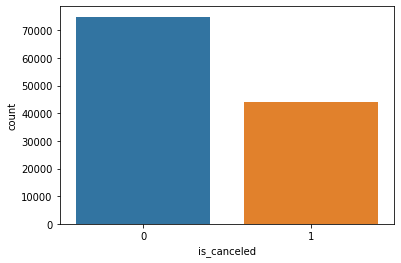

In [ ]:
sns.countplot( x = 'is_canceled', data = df)

Cancellation Groupby hotel Type

<AxesSubplot:xlabel='hotel', ylabel='count'>

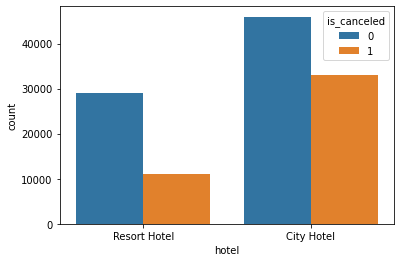

In [ ]:
sns.countplot(x = 'hotel',hue = 'is_canceled', data = df)

In [ ]:
df.groupby('hotel')['is_canceled'].value_counts()

hotel         is_canceled
City Hotel    0              45945
              1              32995
Resort Hotel  0              28927
              1              11120
Name: is_canceled, dtype: int64

City Hotel has higher proportion of cancellation

Question 1: what is the top overall travel season?

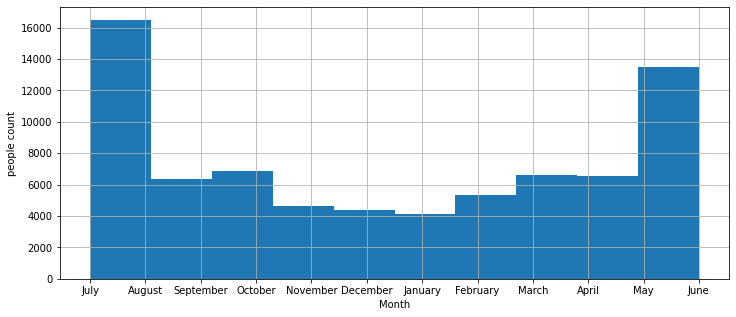

In [ ]:
fig = plt.figure(figsize=(12, 5))
visited['arrival_date_month'].hist()
plt.xlabel('Month')
plt.ylabel('people count')
plt.show()

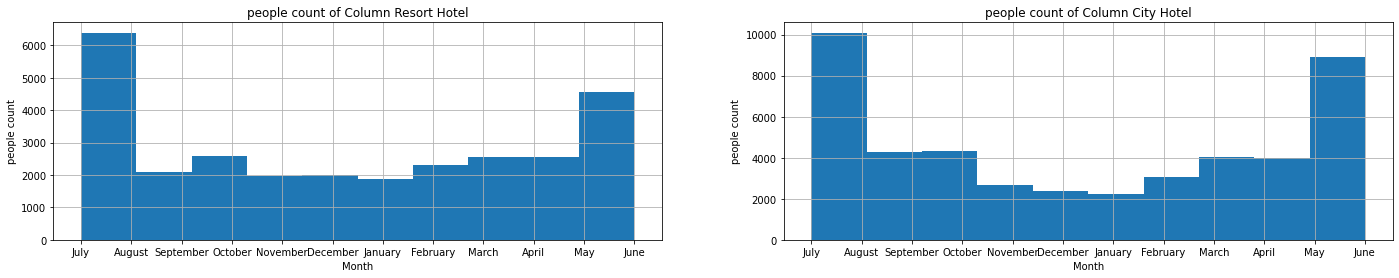

In [ ]:
hotel_type = visited['hotel'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(hotel_type), figsize=(24, 4))
for i,value in enumerate(hotel_type):
  visited.loc[visited['hotel'] == value]['arrival_date_month'].hist(ax=axes[i])
  axes[i].set_title('people count of Column {}'.format(value))
  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('people count')

what kind of the hotel does people with most likely to go?


In [ ]:
df['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [ ]:
visited['hotel'].value_counts()

City Hotel      45945
Resort Hotel    28927
Name: hotel, dtype: int64

<AxesSubplot:xlabel='hotel', ylabel='count'>

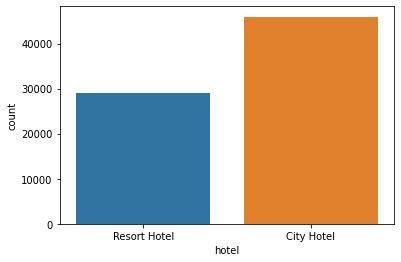

In [ ]:
sns.countplot( x = 'hotel', data = visited)

what kind of the hotel does people with children most likely to go?

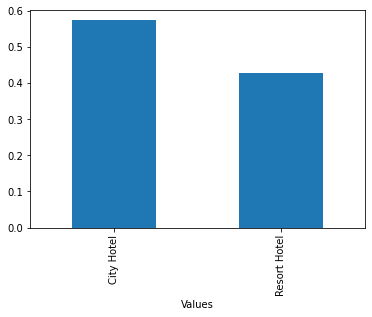

In [ ]:
withBaby = visited.loc[visited['children']+ visited['babies'] >0]
fig = plt.figure(figsize=(6, 4))
hotelPreferRate = withBaby['hotel'].value_counts(normalize = True)
ax = hotelPreferRate.plot(kind = 'bar')
ax.set_xlabel('Values', rotation=0)
plt.show()

should hotel prepare more children stuff in specific month?

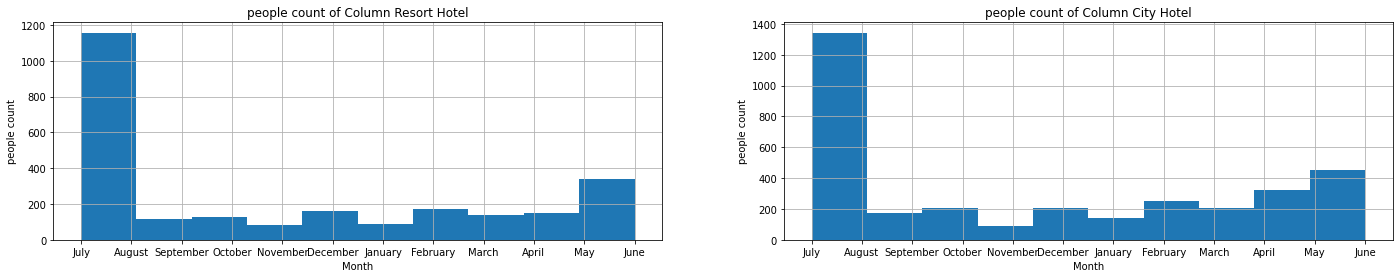

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(hotel_type), figsize=(24, 4))
for i,value in enumerate(withBaby['hotel'].unique()):
  withBaby.loc[withBaby['hotel'] == value]['arrival_date_month'].hist(ax=axes[i])
  axes[i].set_title('people count of Column {}'.format(value))
  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('people count')

does specific year affect which month people want to travel?

In [ ]:
from pandas.core.base import value_counts
fig = plt.figure(figsize=(12, 5))
visited.groupby('arrival_date_year')['arrival_date_month'].value_counts()

arrival_date_year  arrival_date_month
2015               October               3218
                   September             3016
                   August                2281
                   December              1935
                   November              1851
                   July                  1515
2016               October               3669
                   May                   3554
                   September             3365
                   April                 3359
                   March                 3337
                   August                3214
                   June                  3188
                   July                  3053
                   November              2799
                   February              2539
                   December              2442
                   January               1683
2017               May                   3541
                   July                  3316
                   March                 3

<Figure size 864x360 with 0 Axes>

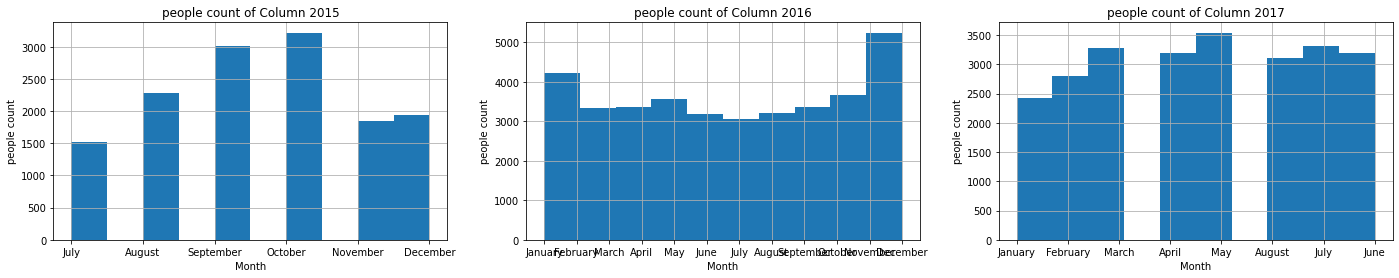

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 4))
for i,value in enumerate(visited['arrival_date_year'].unique()):
  visited.loc[visited['arrival_date_year'] == value]['arrival_date_month'].hist(ax=axes[i])
  axes[i].set_title('people count of Column {}'.format(value))
  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('people count')

does people prefer to arrive at particular day?

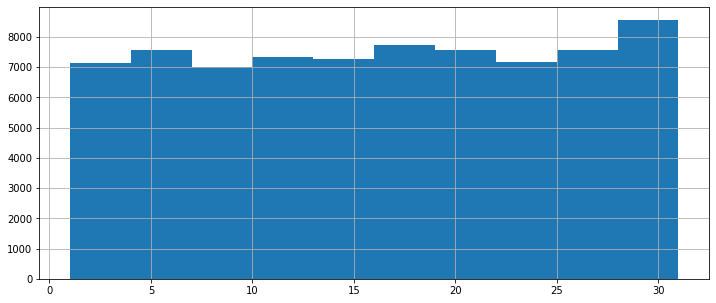

In [ ]:
fig = plt.figure(figsize=(12, 5))
visited['arrival_date_day_of_month'].hist()
# plt.xlabel('Month')
# plt.ylabel('people count')
plt.show()

which country is more porpular? 

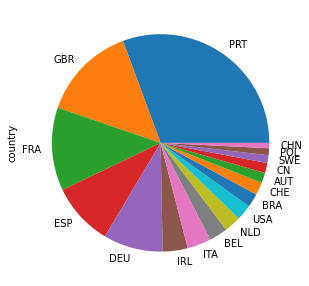

In [ ]:
s = visited['country'].value_counts()>500
idx = s[s.array == True].index
porpularCountries = visited[visited['country'].isin(idx)]['country'].value_counts()
# print(porpularCountries)
fig = plt.figure(figsize=(12, 5))
ax = porpularCountries.plot(kind = 'pie')
plt.show()

what month does people typicaly come in

<function matplotlib.pyplot.show(close=None, block=None)>

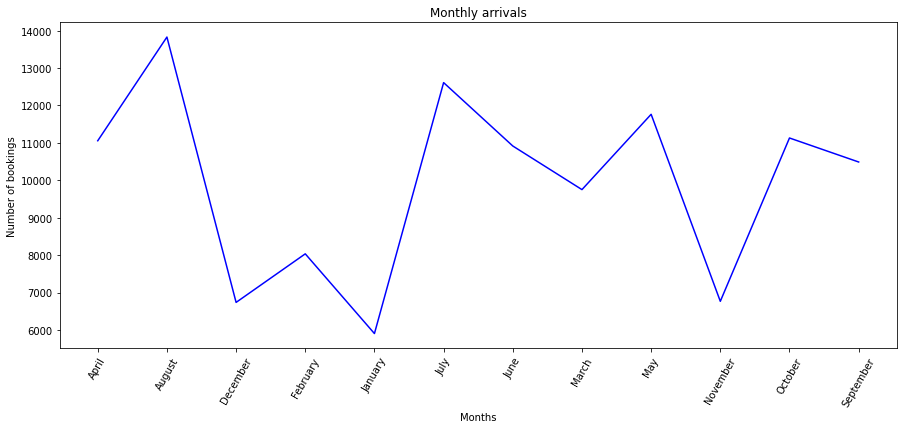

In [ ]:
df_year = df.groupby(['arrival_date_month']).agg({'hotel':'count'}).reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(x = "arrival_date_month",y = 'hotel', data = df_year, color = 'blue' )
plt.xticks(rotation = 60)
plt.title('Monthly arrivals', )
plt.xlabel('Months')
plt.ylabel('Number of bookings')
plt.show

See the Length of Stay

In [ ]:
df['total_stayNights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

Text(0, 0.5, 'No. of Bookings')

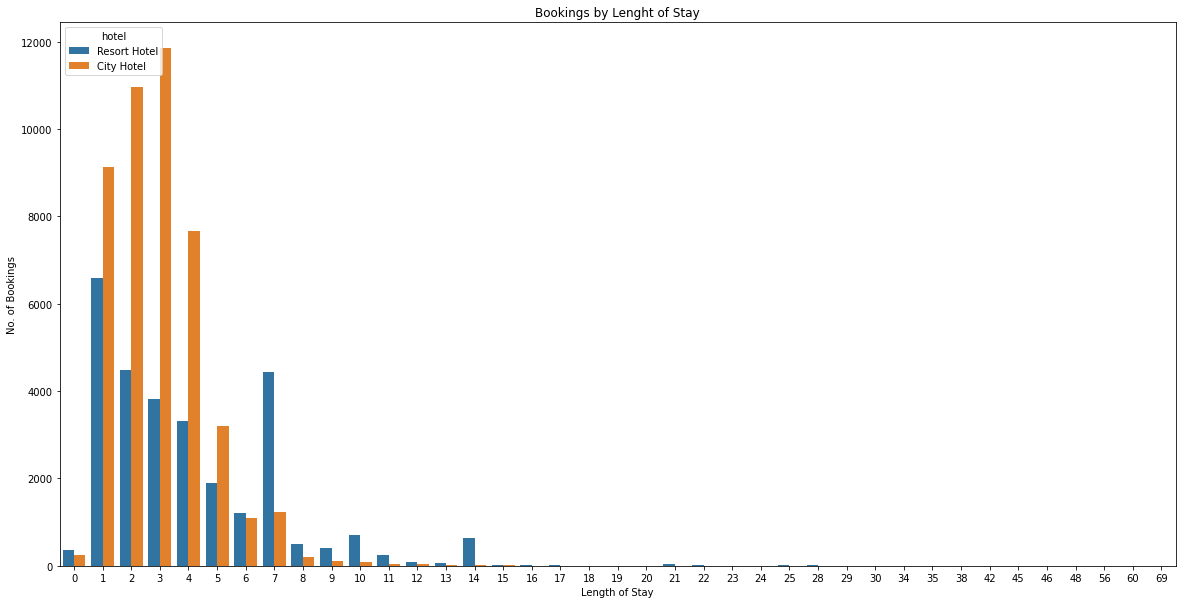

In [ ]:
fig = plt.figure(figsize = (20,10))
sns.countplot(x = 'total_stayNights', data = df.loc[df['is_canceled'] == 0], hue = 'hotel')
plt.title('Bookings by Lenght of Stay')
plt.xlabel('Length of Stay')
plt.ylabel('No. of Bookings')

## **Outlier Detection**

To preserve the dataset, we create a copy for our original dataset 'df' as 'df1

In [234]:
df1 = df.copy()
df1.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,No Deposit,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [100]:
# First we need to find out which features are numeric

In [235]:
numeric_Var_list = []
for i in df1.columns:
  if df1[i].dtypes == 'int64' or df1[i].dtypes == 'float64':
    numeric_Var_list.append(i)
print(numeric_Var_list) 
len(numeric_Var_list)

['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


19

We need to remove 'is_canceled', 'is_repeated_guest' and 'agent'

In [236]:
numeric_Var_list.remove('is_canceled')
numeric_Var_list.remove('is_repeated_guest')
numeric_Var_list.remove('agent')

In [237]:
len(numeric_Var_list) # Now we have 16 variables as numeric features, and we need to detect each of its outliers

16

In [238]:
numeric_Var_list

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [239]:
 #This function calculate the number of outliers of numeric variables with 2 input dataset and column name
def countOutliers(DF, colName): 
  Q1 = np.percentile(DF[colName], 25,
                    interpolation = 'midpoint')
  
  Q3 = np.percentile(DF[colName], 75,
                      interpolation = 'midpoint')
  IQR = Q3 - Q1

  # Upper Bound
  upper=Q3+1.5*IQR
  upper_array= np.array(df1[colName]>upper)
    
  #Below Lower bound
  lower=Q1-1.5*IQR
  lower_array= np.array(df1[colName] < lower)

  # Number of outliers
  numOutliers = len(DF[colName][upper_array])+len(df1[colName][lower_array])
  return numOutliers


In [240]:
numOutliersList = []
for i in numeric_Var_list:
  numOutliersList.append(countOutliers(df1,i))

outliers_df = pd.DataFrame({'Numeric Features': numeric_Var_list, 'Number of Outliers': numOutliersList})
outliers_df

<ipython-input-239-7c302d84a892>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(DF[colName], 25,
<ipython-input-239-7c302d84a892>:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(DF[colName], 75,


,Numeric Features,Number of Outliers
0,lead_time,3003
1,arrival_date_year,0
2,arrival_date_week_number,0
3,arrival_date_day_of_month,0
4,stays_in_weekend_nights,258
5,stays_in_week_nights,3327
6,adults,29307
7,children,8367
8,babies,914
9,previous_cancellations,6477


In [241]:
 #This function return the index of outliers for numeric variables with 2 input dataset and column name
def findOutliers(DF, colName): 
  Q1 = np.percentile(DF[colName], 25,
                    interpolation = 'midpoint')
  
  Q3 = np.percentile(DF[colName], 75,
                      interpolation = 'midpoint')
  IQR = Q3 - Q1

  # Upper Bound
  upper=Q3+1.5*IQR
  upper_array= np.array(df1[colName]>upper)
    
  #Below Lower bound
  lower=Q1-1.5*IQR
  lower_array= np.array(df1[colName] < lower)

  # find the index of outliers
  index_list = []
  for i in range(len(upper_array)):
    if upper_array[i] == True:
      index_list.append(i)
  

  for i in range(len(lower_array)):
    if lower_array[i] == True:
      index_list.append(i)
    

  return index_list


# **Feature Engineering**

Among the 12 categorical variables, we use label encoding to 'reservation_status_date', and one-hot encoding to the rest. 
Since 'country' has a really high cardinality - 178 values, we decide to drop this feature.

To preserve the dataset, we create a copy for our original dataset 'df' as 'df1' to do feature engineering

In [242]:
len(df1.columns)

31

In [243]:
df1=df1.drop(['country'],axis=1)

In [244]:
Categorical_Var_list.remove('country')

In [245]:
len(df1.columns)

30

Now we have 29 features and 1 target variable

In [246]:
# Apply label encoding to ''reservation_status_date''

In [247]:
df1['reservation_status_date']=LabelEncoder().fit_transform(df1['reservation_status_date'])

In [248]:
df1['reservation_status_date']

0         121
1         121
2         122
3         122
4         123
         ... 
119385    919
119386    920
119387    920
119388    920
119389    920
Name: reservation_status_date, Length: 118987, dtype: int64

In [249]:
# Apply one-hot encoding to the other 10 categorical variables
Categorical_Var_list.remove('reservation_status_date')

In [250]:
df1 = pd.get_dummies(df1, columns= Categorical_Var_list)

In [251]:
df1.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status_date',
       'hotel_City Hotel', 'hotel_Resort Hotel', 'arrival_date_month_April',
       'arrival_date_month_August', 'arrival_date_month_December',
       'arrival_date_month_February', 'arrival_date_month_January',
       'arrival_date_month_July', 'arrival_date_month_June',
       'arrival_date_month_March', 'arrival_date_month_May',
       'arrival_date_month_November', 'arrival_date_month_October',
       'arrival_date_month_September', 'meal_BB', 'meal_FB', 'meal_HB',
       'meal_SC', 'market_segment_Aviation', 'market_segment_

**After we use one-hot encoding with get_dummies() function, we end up with 81 variables**

### **Apply Standard Scaler to numeric variables in the data set**

In [252]:
from sklearn.preprocessing import StandardScaler
df1[numeric_Var_list] = StandardScaler().fit_transform(df1[numeric_Var_list])

In [253]:
pd.set_option('display.max_rows', 100)

In [254]:

correlation = df1.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                       1.000000
reservation_status_Check-Out      1.000000
reservation_status_Canceled       0.978442
deposit_type_Non Refund           0.482033
deposit_type_No Deposit           0.478480
lead_time                         0.292983
total_of_special_requests         0.235262
market_segment_Groups             0.222251
assigned_room_type_A              0.197752
required_car_parking_spaces       0.195863
distribution_channel_TA/TO        0.176111
reservation_status_date           0.162236
market_segment_Direct             0.154465
distribution_channel_Direct       0.151660
booking_changes                   0.144863
hotel_Resort Hotel                0.137260
hotel_City Hotel                  0.137260
customer_type_Transient           0.133227
reservation_status_No-Show        0.131661
assigned_room_type_D              0.128429
customer_type_Transient-Party     0.124283
previous_cancellations            0.110222
is_repeated_guest                 0.083797
market_segm

In [255]:
df['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [263]:
# remove the column 'reservation_status_Check-Out' since it has a correlation of 1 which implies a colinearity
# same for 'reservation_status_Canceled'
df1.drop(['reservation_status_Check-Out'], axis=1, inplace = True)

In [265]:
df1.drop(['reservation_status_Canceled'], axis=1, inplace = True)

In [266]:
correlation = df1.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation


is_canceled                       1.000000
deposit_type_Non Refund           0.482033
deposit_type_No Deposit           0.478480
lead_time                         0.292983
total_of_special_requests         0.235262
market_segment_Groups             0.222251
assigned_room_type_A              0.197752
required_car_parking_spaces       0.195863
distribution_channel_TA/TO        0.176111
reservation_status_date           0.162236
market_segment_Direct             0.154465
distribution_channel_Direct       0.151660
booking_changes                   0.144863
hotel_Resort Hotel                0.137260
hotel_City Hotel                  0.137260
customer_type_Transient           0.133227
reservation_status_No-Show        0.131661
assigned_room_type_D              0.128429
customer_type_Transient-Party     0.124283
previous_cancellations            0.110222
is_repeated_guest                 0.083797
market_segment_Corporate          0.081720
distribution_channel_Corporate    0.075659
reserved_ro

Now we see the attribute 'reservation_status_Check-Out' and 'reservation_status_Canceled' has been removed

We will use Variance Inflation Factor (VIF) later to further investigate colinearity and improve our method of incorporating features into our model. 

# **Model Building**

For now we select the following 19 features (correlation > 0.1) into our model:


In [267]:
feature_name_list = ["deposit_type_Non Refund",    "deposit_type_No Deposit",    "lead_time",    "total_of_special_requests",   
                     "market_segment_Groups",    "assigned_room_type_A",    "required_car_parking_spaces",    "distribution_channel_TA/TO",  
                     "reservation_status_date",    "market_segment_Direct",    "distribution_channel_Direct",    "booking_changes",    "hotel_Resort Hotel",  
                     "hotel_City Hotel",    "customer_type_Transient",    "reservation_status_No-Show",    "assigned_room_type_D",  
                     "customer_type_Transient-Party",    "previous_cancellations"]


In [271]:
X = df1[feature_name_list]
y = df1['is_canceled']

In [273]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### **Logistic Regression**

In [274]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
conf_lr = confusion_matrix(y_test, y_pred_lr)
classReport_lr = classification_report(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}")
print(f"Confusion Matrix : \n{conf_lr}")
print(f"Classification Report : \n{classReport_lr}")

Accuracy Score of Logistic Regression is : 0.7815222567722778
Confusion Matrix : 
[[21739   685]
 [ 7114  6159]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.75      0.97      0.85     22424
           1       0.90      0.46      0.61     13273

    accuracy                           0.78     35697
   macro avg       0.83      0.72      0.73     35697
weighted avg       0.81      0.78      0.76     35697



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### **Decision Tree**

In [275]:
decTree = DecisionTreeClassifier()
decTree.fit(X_train, y_train)

y_pred_decT = decTree.predict(X_test)

acc_decT = accuracy_score(y_test, y_pred_decT)
conf_decT = confusion_matrix(y_test, y_pred_decT)
classReport_decT = classification_report(y_test, y_pred_decT)

print(f"Accuracy Score of Decision Tree is : {acc_decT}")
print(f"Confusion Matrix : \n{conf_decT}")
print(f"Classification Report : \n{classReport_decT}")

Accuracy Score of Decision Tree is : 0.8527327226377567
Confusion Matrix : 
[[19810  2614]
 [ 2643 10630]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     22424
           1       0.80      0.80      0.80     13273

    accuracy                           0.85     35697
   macro avg       0.84      0.84      0.84     35697
weighted avg       0.85      0.85      0.85     35697



### **Random Forest**

In [276]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

acc_rfc = accuracy_score(y_test, y_pred_rfc)
conf_rfc = confusion_matrix(y_test, y_pred_rfc)
classReport_rfc = classification_report(y_test, y_pred_rfc)

print(f"Accuracy Score of Random Forest is : {acc_rfc}")
print(f"Confusion Matrix : \n{conf_rfc}")
print(f"Classification Report : \n{classReport_rfc}")

Accuracy Score of Random Forest is : 0.8765442474157492
Confusion Matrix : 
[[20734  1690]
 [ 2717 10556]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     22424
           1       0.86      0.80      0.83     13273

    accuracy                           0.88     35697
   macro avg       0.87      0.86      0.87     35697
weighted avg       0.88      0.88      0.88     35697



### **XGB Classifier**

In [277]:
xgb = RandomForestClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
conf_xgb = confusion_matrix(y_test, y_pred_xgb)
classReport_xgb = classification_report(y_test, y_pred_xgb)

print(f"Accuracy Score of Random Forest is : {acc_xgb}")
print(f"Confusion Matrix : \n{conf_xgb}")
print(f"Classification Report : \n{classReport_xgb}")

Accuracy Score of Random Forest is : 0.8766563016499986
Confusion Matrix : 
[[20744  1680]
 [ 2723 10550]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     22424
           1       0.86      0.79      0.83     13273

    accuracy                           0.88     35697
   macro avg       0.87      0.86      0.87     35697
weighted avg       0.88      0.88      0.88     35697

